In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Convolve
from scipy.ndimage import gaussian_filter1d
from cca_zoo.linear import rCCA
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# Directories
main_dir = os.getcwd()
model_cache_dir = os.path.join(main_dir, '..', 'model_cache')

# Set default type now
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

# To-do list:
- [X] New dataset and dataloader setup
- [X] Train/test split as function so repeated calls get different splits
- [X] Make infoNCE inference chunked so it can run on large datasets
- [X] Version of train code for not running eval
- [X] Version of train code that saves models, infrastructure for model handling and retrieval
- [X] Kernel convolution with spikes to get continuous form, run MI
- [X] Change batch indices to just save starts, ends rather than store so many index values

- [/] Parallel training with shared memory, fixed to have the right number of processes
- [X] Fix nan issue, likely kernel convolution scaling
- [X] See if I can improve chunked inference
- [X] Try out DVSIB

In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: cuda


In [3]:
# To be fully centered kernel should have odd number of elements!
# Requires torch tensors as both inputs
def convolve_spike_train(X, kernel):
    kernel_len = len(kernel)
    offset = (kernel_len - 1) // 2
    all_inds = torch.nonzero(X, as_tuple=True)
    # Create output array as zero-padded input 
    X = torch.zeros(X.shape[0], X.shape[1] + 2 * offset, dtype=kernel.dtype)
    # Can't think of a way to do this vectorized b/c I'm lazy
    for i in range(X.shape[0]):
        inds = all_inds[1][all_inds[0] == i] + offset
        for j in inds:
            low_ind = j - offset
            high_ind = j - offset + kernel_len
            X[i,low_ind:high_ind] += kernel
    # Remove padding
    X = X[:, offset:-offset]
    return X

Neurons (X): torch.Size([32, 1865558])
Muscles (Y): torch.Size([10, 1865558])
Neuron Labels: ['87', '29', '1', '78', '12', '20', '2', '6', '41', '11', '13', '65', '89', '15', '75', '42', '33', '28', '14', '39', '21', '7', '96', '68', '8', '88', '93', '26', '10', '0', '30', '3']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


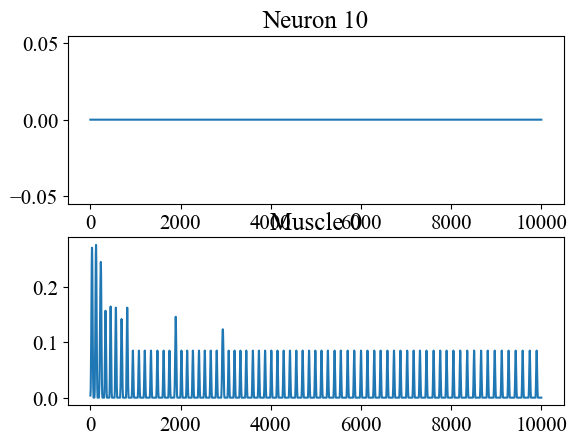

In [4]:
# Read the data and have some binning
data_dir = os.path.join(os.getcwd(), '..', 'data_for_python')
X, Y, x_labels, y_labels = process_spike_data(os.path.join(data_dir, '2025-03-21'), 0.001)
# Convert to torch tensors, "Convolve" with gaussian to get continuous form
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
kernel = torch.signal.windows.gaussian(51, std=10, dtype=torch.float32).type(default_dtype)
X, Y = convolve_spike_train(X, kernel), convolve_spike_train(Y, kernel)
# Clip low values to zero so batch detection works okay
X[X < 0.01] = 0.
Y[Y < 0.01] = 0.
# Rescale all values to same scale
maxval = torch.maximum(X.max(), Y.max())
X /= maxval
Y /= maxval

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

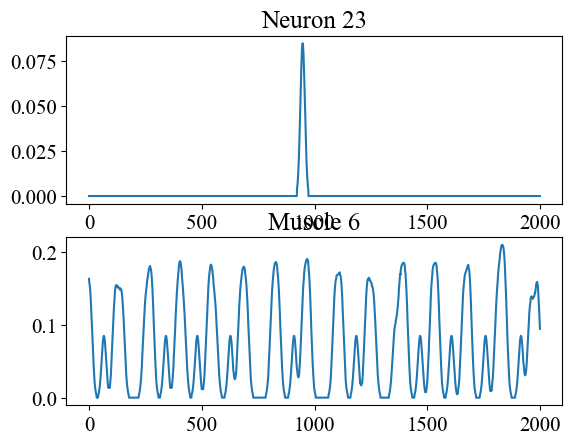

In [5]:
pl = 2000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

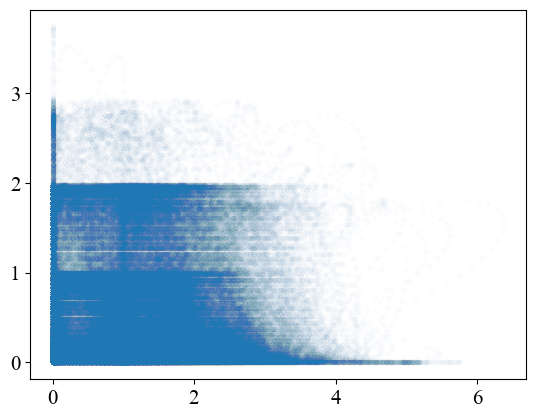

In [70]:
plt.plot(X[24,:], Y[4,:], '.', alpha=0.01)

In [5]:
params = {
    # Optimizer parameters (for training)
    'epochs': 200,
    'batch_size': 128,
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    # 'Nx': 1,
    # 'Ny': 1,
    'layers': 3,
    'hidden_dim': 512,
    'activation': 'softplus', #'leaky_relu',
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'chunked_inference': True, 
    'chunk_size': 1000,
}

# Make dataset
# dataset = BatchedDataset(X, Y, params['batch_size'])
# full_dataset = create_data_split(dataset, train_fraction=0.95, device=device)

In [7]:
torch.cuda.empty_cache()
this_params = {**params, 'embed_dim': 10, 'batch_size': 256}
dataset = BatchedDataset(X, Y, this_params['batch_size'])
full_dataset = create_data_split(dataset, train_fraction=0.9, eval_fraction=0.2, device=device)
mis, mis_test = train_model(DSIB, full_dataset, this_params)
# misv, misv_test = train_model(DVSIB, full_dataset, this_params)

Train time = 4.252866983413696
Eval time = 1.0429480075836182
Test time = 0.26824426651000977
Epoch: 1, DSIB, train: 0.15799808502197266, test: 0.17935943603515625
Train time = 3.989628314971924
Eval time = 1.3622393608093262
Test time = 0.35732340812683105
Epoch: 2, DSIB, train: 0.14925861358642578, test: 0.17667293548583984
Train time = 3.982621192932129
Eval time = 1.0849864482879639
Test time = 0.2907717227935791
Epoch: 3, DSIB, train: 0.15470314025878906, test: 0.18010616302490234
Train time = 4.034669399261475
Eval time = 1.055959701538086
Test time = 0.2772524356842041
Epoch: 4, DSIB, train: 0.15896892547607422, test: 0.18338584899902344
Train time = 4.462057590484619
Eval time = 1.0359423160552979
Test time = 0.2922654151916504
Epoch: 5, DSIB, train: 0.13749313354492188, test: 0.1682300567626953
Train time = 4.104732513427734
Eval time = 1.0629677772521973
Test time = 0.26824283599853516
Epoch: 6, DSIB, train: 0.1546945571899414, test: 0.18377399444580078
Train time = 4.2318489

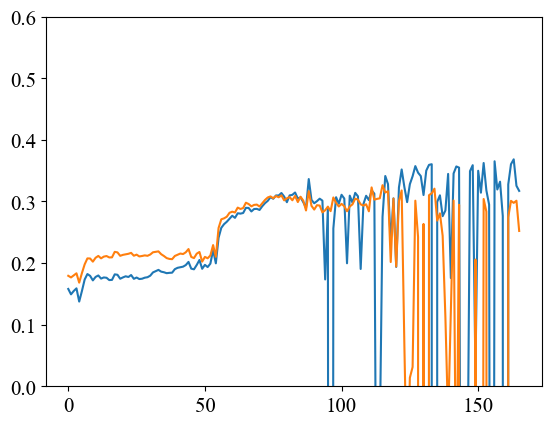

NameError: name 'misv' is not defined

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure()
plt.plot(mis)
plt.plot(mis_test)
plt.gca().set_ylim(0, 0.6)
plt.show()
plt.figure()
plt.plot(misv)
plt.plot(misv_test)
plt.show()

In [20]:
burn_in = 1
np.argmax(mis_test[burn_in:]) + burn_in

np.int64(17)

In [ ]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([64, 128, 256, 512])

for bs in batch_size_range:
    dataset = BatchedDataset(X, Y, bs)
    for dz in tqdm(range(5, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            full_dataset = create_data_split(dataset, train_fraction=0.9, eval_fraction=0.1, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            # mi[f"trial_{j}_dz_{dz}_bs_{bs}"] = mis
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi_test[key] = mis_test
            models[key] = mod
            ids[key] = train_id


  0%|          | 0/8 [00:00<?, ?it/s]

Starting dz = 5


  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 64, dz = 5, trial = 1
Train time = 16.29282259941101
Test time = 0.31829094886779785
Epoch: 1, DSIB, test: 1.9073486328125e-06
Train time = 16.068612337112427
Test time = 0.3092820644378662
Epoch: 2, DSIB, test: -9.5367431640625e-07
Train time = 16.74807047843933
Test time = 0.3268771171569824
Epoch: 3, DSIB, test: -2.86102294921875e-06
Train time = 16.26138424873352
Test time = 0.3473165035247803
Epoch: 4, DSIB, test: -1.239776611328125e-05
Train time = 16.44728660583496
Test time = 0.27124714851379395
Epoch: 5, DSIB, test: -2.86102294921875e-06
Train time = 15.874443054199219
Test time = 0.37033748626708984
Epoch: 6, DSIB, test: 2.86102294921875e-06
Train time = 16.127666234970093
Test time = 0.28826355934143066
Epoch: 7, DSIB, test: 1.049041748046875e-05
Train time = 16.542045831680298
Test time = 0.31829023361206055
Epoch: 8, DSIB, test: 1.049041748046875e-05
Train time = 16.363880157470703
Test time = 0.28325796127319336
Epoch: 9, DSIB, test: 1.049041748046875e-05
Tra

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 64, dz = 6, trial = 1
Train time = 16.46895980834961
Test time = 0.3222930431365967
Epoch: 1, DSIB, test: 1.9073486328125e-06
Train time = 16.20532774925232
Test time = 0.2942681312561035
Epoch: 2, DSIB, test: 1.9073486328125e-06
Train time = 15.833484411239624
Test time = 0.36032748222351074
Epoch: 3, DSIB, test: 0.0
Train time = 16.362883806228638
Test time = 0.3413102626800537
Epoch: 4, DSIB, test: -1.9073486328125e-06
Train time = 16.59208846092224
Test time = 0.33030056953430176
Epoch: 5, DSIB, test: -1.9073486328125e-06
Train time = 16.25077795982361
Test time = 0.28826284408569336
Epoch: 6, DSIB, test: 0.0
Train time = 16.070261240005493
Test time = 0.32029223442077637
Epoch: 7, DSIB, test: -1.9073486328125e-06
Train time = 15.966519594192505
Test time = 0.2792544364929199
Epoch: 8, DSIB, test: -9.5367431640625e-07
Train time = 16.653199195861816
Test time = 0.30803823471069336
Epoch: 9, DSIB, test: 2.86102294921875e-06
Train time = 16.218988180160522
Test time = 0.

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 64, dz = 7, trial = 1
Train time = 16.013387441635132
Test time = 0.30828118324279785
Epoch: 1, DSIB, test: -9.5367431640625e-07
Train time = 16.142837524414062
Test time = 0.37033700942993164
Epoch: 2, DSIB, test: -1.9073486328125e-06
Train time = 16.410255432128906
Test time = 0.28325843811035156
Epoch: 3, DSIB, test: 9.5367431640625e-07
Train time = 16.326552629470825
Test time = 0.31528687477111816
Epoch: 4, DSIB, test: 1.049041748046875e-05
Train time = 16.098317623138428
Test time = 0.27625155448913574
Epoch: 5, DSIB, test: -1.9073486328125e-06
Train time = 15.81056022644043
Test time = 0.30627870559692383
Epoch: 6, DSIB, test: 2.574920654296875e-05
Train time = 16.415931224822998
Test time = 0.2772529125213623
Epoch: 7, DSIB, test: 1.049041748046875e-05
Train time = 16.480332612991333
Test time = 0.32029151916503906
Epoch: 8, DSIB, test: 1.33514404296875e-05
Train time = 16.33677339553833
Test time = 0.3363056182861328
Epoch: 9, DSIB, test: -2.86102294921875e-06
Tra

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 64, dz = 8, trial = 1
Train time = 15.91353178024292
Test time = 0.29126477241516113
Epoch: 1, DSIB, test: 9.5367431640625e-07
Train time = 16.120542764663696
Test time = 0.35031890869140625
Epoch: 2, DSIB, test: -4.76837158203125e-06
Train time = 16.873170614242554
Test time = 0.27625203132629395
Epoch: 3, DSIB, test: -1.9073486328125e-06
Train time = 16.5560564994812
Test time = 0.2922666072845459
Epoch: 4, DSIB, test: 0.00011920928955078125
Train time = 15.864427328109741
Test time = 0.2752513885498047
Epoch: 5, DSIB, test: 0.0001201629638671875
Train time = 16.082863569259644
Test time = 0.33030080795288086
Epoch: 6, DSIB, test: 0.0001239776611328125
Train time = 16.78026032447815
Test time = 0.28325748443603516
Epoch: 7, DSIB, test: 0.00011920928955078125
Train time = 16.41793131828308
Test time = 0.2892625331878662
Epoch: 8, DSIB, test: 9.72747802734375e-05
Train time = 16.381900310516357
Test time = 0.37734341621398926
Epoch: 9, DSIB, test: 0.0001201629638671875
Tra

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 64, dz = 9, trial = 1
Train time = 16.606151819229126
Test time = 0.3122844696044922
Epoch: 1, DSIB, test: -9.5367431640625e-07
Train time = 16.39590835571289
Test time = 0.2902650833129883
Epoch: 2, DSIB, test: -2.86102294921875e-06
Train time = 16.535397052764893
Test time = 0.31028223037719727
Epoch: 3, DSIB, test: -3.814697265625e-06
Train time = 16.094691276550293
Test time = 0.2872614860534668
Epoch: 4, DSIB, test: 0.0
Train time = 15.876011848449707
Test time = 0.3192901611328125
Epoch: 5, DSIB, test: -9.5367431640625e-07
Train time = 16.856199979782104
Test time = 0.3463144302368164
Epoch: 6, DSIB, test: -1.049041748046875e-05
Train time = 16.591091632843018
Test time = 0.314286470413208
Epoch: 7, DSIB, test: 1.049041748046875e-05
Train time = 16.278517961502075
Test time = 0.3743412494659424
Epoch: 8, DSIB, test: -2.86102294921875e-06
Train time = 15.836405277252197
Test time = 0.2852590084075928
Epoch: 9, DSIB, test: 1.049041748046875e-05
Train time = 16.55506753

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 64, dz = 10, trial = 1
Train time = 16.07662320137024
Test time = 0.2892634868621826
Epoch: 1, DSIB, test: 0.007039070129394531
Train time = 16.718154668807983
Test time = 0.3262972831726074
Epoch: 2, DSIB, test: 0.06762504577636719
Train time = 16.549275159835815
Test time = 0.28325724601745605
Epoch: 3, DSIB, test: 0.1627664566040039
Train time = 16.384899139404297
Test time = 0.2952694892883301
Epoch: 4, DSIB, test: 0.1749401092529297
Train time = 15.747140884399414
Test time = 0.3963606357574463
Epoch: 5, DSIB, test: 0.1743907928466797
Train time = 16.32655429840088
Test time = 0.2792537212371826
Epoch: 6, DSIB, test: 0.1769237518310547
Train time = 16.72721815109253
Test time = 0.3443131446838379
Epoch: 7, DSIB, test: 0.1800985336303711
Train time = 16.354077100753784
Test time = 0.29135560989379883
Epoch: 8, DSIB, test: 0.178009033203125
Train time = 16.255789279937744
Test time = 0.38034605979919434
Epoch: 9, DSIB, test: 0.17409896850585938
Train time = 16.022475004

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 64, dz = 11, trial = 1
Train time = 16.318846225738525
Test time = 0.33830833435058594
Epoch: 1, DSIB, test: -9.5367431640625e-07
Train time = 16.119704484939575
Test time = 0.3108668327331543
Epoch: 2, DSIB, test: -2.86102294921875e-06
Train time = 16.047318935394287
Test time = 0.3713381290435791
Epoch: 3, DSIB, test: -1.9073486328125e-06
Train time = 16.71712040901184
Test time = 0.29827189445495605
Epoch: 4, DSIB, test: 8.58306884765625e-06
Train time = 16.350436449050903
Test time = 0.31328558921813965
Epoch: 5, DSIB, test: 1.049041748046875e-05
Train time = 15.860202312469482
Test time = 0.2892634868621826
Epoch: 6, DSIB, test: 2.574920654296875e-05
Train time = 15.885115146636963
Test time = 0.3323030471801758
Epoch: 7, DSIB, test: 1.049041748046875e-05
Train time = 16.737798929214478
Test time = 0.2942683696746826
Epoch: 8, DSIB, test: 1.049041748046875e-05
Train time = 16.310697078704834
Test time = 0.31028294563293457
Epoch: 9, DSIB, test: 1.049041748046875e-05
T

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 64, dz = 12, trial = 1
Train time = 15.90810513496399
Test time = 0.322293758392334
Epoch: 1, DSIB, test: -1.9073486328125e-06
Train time = 16.661521673202515
Test time = 0.28626084327697754
Epoch: 2, DSIB, test: -1.9073486328125e-06
Train time = 16.63649082183838
Test time = 0.3142857551574707
Epoch: 3, DSIB, test: 1.049041748046875e-05
Train time = 16.754236459732056
Test time = 0.3072795867919922
Epoch: 4, DSIB, test: 3.814697265625e-06
Train time = 16.072616577148438
Test time = 0.27625131607055664
Epoch: 5, DSIB, test: 1.811981201171875e-05
Train time = 16.095143795013428
Test time = 0.3192908763885498
Epoch: 6, DSIB, test: -4.76837158203125e-06
Train time = 16.899873971939087
Test time = 0.31128406524658203
Epoch: 7, DSIB, test: 1.049041748046875e-05
Train time = 16.503021240234375
Test time = 0.3373069763183594
Epoch: 8, DSIB, test: 1.049041748046875e-05
Train time = 16.105084896087646
Test time = 0.284259557723999
Epoch: 9, DSIB, test: 1.049041748046875e-05
Train t

  0%|          | 0/8 [00:00<?, ?it/s]

Starting dz = 5


  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 128, dz = 5, trial = 1
Train time = 8.1678466796875
Test time = 0.28684163093566895
Epoch: 1, DSIB, test: -1.9073486328125e-06
Train time = 8.529321670532227
Test time = 0.2722475528717041
Epoch: 2, DSIB, test: 0.0
Train time = 8.30841588973999
Test time = 0.3463153839111328
Epoch: 3, DSIB, test: 7.62939453125e-06
Train time = 8.249502897262573
Test time = 0.31028175354003906
Epoch: 4, DSIB, test: -9.5367431640625e-07
Train time = 8.258017778396606
Test time = 0.314286470413208
Epoch: 5, DSIB, test: -2.86102294921875e-06
Train time = 8.237491130828857
Test time = 0.287261962890625
Epoch: 6, DSIB, test: -1.9073486328125e-06
Train time = 8.124389171600342
Test time = 0.336306095123291
Epoch: 7, DSIB, test: 0.0
Train time = 8.103369951248169
Test time = 0.30327606201171875
Epoch: 8, DSIB, test: 0.0
Train time = 8.145407676696777
Test time = 0.2892639636993408
Epoch: 9, DSIB, test: -1.1444091796875e-05
Train time = 8.245498180389404
Test time = 0.32329487800598145
Epoch: 10, D

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 128, dz = 6, trial = 1
Train time = 8.436676025390625
Test time = 0.40819621086120605
Epoch: 1, DSIB, test: 0.0
Train time = 8.363394975662231
Test time = 0.3122842311859131
Epoch: 2, DSIB, test: 9.5367431640625e-07
Train time = 8.368610620498657
Test time = 0.28826212882995605
Epoch: 3, DSIB, test: -9.5367431640625e-07
Train time = 8.270521402359009
Test time = 0.3643314838409424
Epoch: 4, DSIB, test: 9.5367431640625e-07
Train time = 8.126787424087524
Test time = 0.2902641296386719
Epoch: 5, DSIB, test: -2.86102294921875e-06
Train time = 8.073341846466064
Test time = 0.2842583656311035
Epoch: 6, DSIB, test: -3.814697265625e-06
Train time = 7.999274253845215
Test time = 0.2742493152618408
Epoch: 7, DSIB, test: -9.5367431640625e-07
Train time = 8.459693431854248
Test time = 0.39736127853393555
Epoch: 8, DSIB, test: -1.9073486328125e-06
Train time = 8.546772956848145
Test time = 0.30827999114990234
Epoch: 9, DSIB, test: 0.0
Train time = 8.35159420967102
Test time = 0.3092815

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 128, dz = 7, trial = 1
Train time = 7.998274087905884
Test time = 0.27825307846069336
Epoch: 1, DSIB, test: 0.0
Train time = 8.25150442123413
Test time = 0.34831690788269043
Epoch: 2, DSIB, test: 0.0
Train time = 8.18344235420227
Test time = 0.30027294158935547
Epoch: 3, DSIB, test: 0.0
Train time = 8.584808111190796
Test time = 0.27825284004211426
Epoch: 4, DSIB, test: 9.5367431640625e-07
Train time = 8.381622076034546
Test time = 0.3643312454223633
Epoch: 5, DSIB, test: 0.0
Train time = 8.300548791885376
Test time = 0.3042762279510498
Epoch: 6, DSIB, test: -9.5367431640625e-07
Train time = 8.237674951553345
Test time = 0.2790703773498535
Epoch: 7, DSIB, test: -9.5367431640625e-07
Train time = 8.269520044326782
Test time = 0.2952687740325928
Epoch: 8, DSIB, test: -9.5367431640625e-07
Train time = 8.243496894836426
Test time = 0.3633303642272949
Epoch: 9, DSIB, test: -9.5367431640625e-07
Train time = 8.146409273147583
Test time = 0.28125572204589844
Epoch: 10, DSIB, test: 

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 128, dz = 8, trial = 1
Train time = 8.321155071258545
Test time = 0.39435911178588867
Epoch: 1, DSIB, test: -9.5367431640625e-07
Train time = 8.257509231567383
Test time = 0.31628847122192383
Epoch: 2, DSIB, test: 1.9073486328125e-06
Train time = 8.140403509140015
Test time = 0.30027294158935547
Epoch: 3, DSIB, test: -9.5367431640625e-06
Train time = 8.073341608047485
Test time = 0.2752504348754883
Epoch: 4, DSIB, test: 2.574920654296875e-05
Train time = 8.186444282531738
Test time = 0.37734389305114746
Epoch: 5, DSIB, test: -1.9073486328125e-06
Train time = 8.175439596176147
Test time = 0.309281587600708
Epoch: 6, DSIB, test: 1.33514404296875e-05
Train time = 8.625844478607178
Test time = 0.2722480297088623
Epoch: 7, DSIB, test: -2.956390380859375e-05
Train time = 8.370612144470215
Test time = 0.2822573184967041
Epoch: 8, DSIB, test: -1.52587890625e-05
Train time = 8.286535739898682
Test time = 0.2972707748413086
Epoch: 9, DSIB, test: -4.57763671875e-05
Train time = 8.269

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 128, dz = 9, trial = 1
Train time = 8.236214876174927
Test time = 0.28325819969177246
Epoch: 1, DSIB, test: 0.0
Train time = 8.14540696144104
Test time = 0.300274133682251
Epoch: 2, DSIB, test: -9.5367431640625e-07
Train time = 8.111375570297241
Test time = 0.3112831115722656
Epoch: 3, DSIB, test: 9.5367431640625e-07
Train time = 8.108373880386353
Test time = 0.3262965679168701
Epoch: 4, DSIB, test: -9.5367431640625e-07
Train time = 8.477712631225586
Test time = 0.2822566032409668
Epoch: 5, DSIB, test: 9.5367431640625e-07
Train time = 8.383624076843262
Test time = 0.3563244342803955
Epoch: 6, DSIB, test: 1.9073486328125e-06
Train time = 8.411649703979492
Test time = 0.31528711318969727
Epoch: 7, DSIB, test: -2.86102294921875e-06
Train time = 8.319566011428833
Test time = 0.30027294158935547
Epoch: 8, DSIB, test: -4.76837158203125e-06
Train time = 8.347590684890747
Test time = 0.2772524356842041
Epoch: 9, DSIB, test: 0.0
Train time = 8.08653736114502
Test time = 0.284257411

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 128, dz = 10, trial = 1
Train time = 8.286164045333862
Test time = 0.2822566032409668
Epoch: 1, DSIB, test: 0.0
Train time = 8.12238597869873
Test time = 0.2802553176879883
Epoch: 2, DSIB, test: -9.5367431640625e-07
Train time = 8.137399673461914
Test time = 0.34231114387512207
Epoch: 3, DSIB, test: -9.5367431640625e-07
Train time = 8.215471267700195
Test time = 0.3172893524169922
Epoch: 4, DSIB, test: 9.5367431640625e-07
Train time = 8.602823734283447
Test time = 0.32829856872558594
Epoch: 5, DSIB, test: -9.5367431640625e-07
Train time = 8.45869255065918
Test time = 0.33830809593200684
Epoch: 6, DSIB, test: 0.0
Train time = 8.332577466964722
Test time = 0.2822573184967041
Epoch: 7, DSIB, test: 0.0
Train time = 8.32657241821289
Test time = 0.274249792098999
Epoch: 8, DSIB, test: -9.5367431640625e-07
Train time = 8.284533500671387
Test time = 0.28325796127319336
Epoch: 9, DSIB, test: 9.5367431640625e-07
Train time = 8.262514114379883
Test time = 0.3543217182159424
Epoch: 10

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 128, dz = 11, trial = 1
Train time = 8.296544313430786
Test time = 0.33530497550964355
Epoch: 1, DSIB, test: -1.9073486328125e-06
Train time = 8.611830949783325
Test time = 0.3242955207824707
Epoch: 2, DSIB, test: -1.9073486328125e-06
Train time = 8.40064001083374
Test time = 0.31028270721435547
Epoch: 3, DSIB, test: 0.0
Train time = 8.302550792694092
Test time = 0.2772512435913086
Epoch: 4, DSIB, test: -9.5367431640625e-07
Train time = 8.380621671676636
Test time = 0.3513195514678955
Epoch: 5, DSIB, test: -9.5367431640625e-07
Train time = 8.422658681869507
Test time = 0.34831714630126953
Epoch: 6, DSIB, test: -9.5367431640625e-07
Train time = 8.208464860916138
Test time = 0.2742490768432617
Epoch: 7, DSIB, test: 0.0
Train time = 8.160420894622803
Test time = 0.3793461322784424
Epoch: 8, DSIB, test: 0.0
Train time = 8.115379810333252
Test time = 0.32829928398132324
Epoch: 9, DSIB, test: -9.5367431640625e-07
Train time = 8.33658218383789
Test time = 0.3072803020477295
Epoch

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 128, dz = 12, trial = 1
Train time = 8.110838651657104
Test time = 0.3212926387786865
Epoch: 1, DSIB, test: 0.0
Train time = 8.065335273742676
Test time = 0.3463149070739746
Epoch: 2, DSIB, test: 9.5367431640625e-07
Train time = 8.702914476394653
Test time = 0.3212926387786865
Epoch: 3, DSIB, test: -9.5367431640625e-07
Train time = 8.475708246231079
Test time = 0.27324843406677246
Epoch: 4, DSIB, test: -9.5367431640625e-07
Train time = 8.407645225524902
Test time = 0.28826212882995605
Epoch: 5, DSIB, test: 0.0
Train time = 8.359602212905884
Test time = 0.3242950439453125
Epoch: 6, DSIB, test: -1.9073486328125e-06
Train time = 8.341586589813232
Test time = 0.3222928047180176
Epoch: 7, DSIB, test: -9.5367431640625e-07
Train time = 8.095362424850464
Test time = 0.290264368057251
Epoch: 8, DSIB, test: -4.76837158203125e-06
Train time = 8.104369878768921
Test time = 0.3733396530151367
Epoch: 9, DSIB, test: 0.0
Train time = 8.228482961654663
Test time = 0.3212919235229492
Epoch:

  0%|          | 0/8 [00:00<?, ?it/s]

Starting dz = 5


  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 256, dz = 5, trial = 1
Train time = 4.383985996246338
Test time = 0.28826308250427246
Epoch: 1, DSIB, test: 9.5367431640625e-07
Train time = 4.384988307952881
Test time = 0.28826189041137695
Epoch: 2, DSIB, test: 1.9073486328125e-06
Train time = 4.359965085983276
Test time = 0.30027318000793457
Epoch: 3, DSIB, test: -9.5367431640625e-07
Train time = 4.364969730377197
Test time = 0.3643310070037842
Epoch: 4, DSIB, test: -1.9073486328125e-06
Train time = 4.280893802642822
Test time = 0.38735198974609375
Epoch: 5, DSIB, test: 9.5367431640625e-07
Train time = 4.272886514663696
Test time = 0.3042764663696289
Epoch: 6, DSIB, test: -9.5367431640625e-07
Train time = 4.263877868652344
Test time = 0.30828022956848145
Epoch: 7, DSIB, test: -1.9073486328125e-06
Train time = 4.236853361129761
Test time = 0.3172881603240967
Epoch: 8, DSIB, test: 0.0
Train time = 4.2368528842926025
Test time = 0.2942674160003662
Epoch: 9, DSIB, test: -1.9073486328125e-06
Train time = 4.245861291885376
Te

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 256, dz = 6, trial = 1
Train time = 4.440591096878052
Test time = 0.3313014507293701
Epoch: 1, DSIB, test: 0.14480113983154297
Train time = 4.387990951538086
Test time = 0.344313383102417
Epoch: 2, DSIB, test: 0.15292835235595703
Train time = 4.386989116668701
Test time = 0.31528687477111816
Epoch: 3, DSIB, test: 0.1523294448852539
Train time = 4.375978946685791
Test time = 0.2942686080932617
Epoch: 4, DSIB, test: 0.15383243560791016
Train time = 4.349956274032593
Test time = 0.36032772064208984
Epoch: 5, DSIB, test: 0.1540231704711914
Train time = 4.264547109603882
Test time = 0.3633308410644531
Epoch: 6, DSIB, test: 0.18142127990722656
Train time = 4.227844953536987
Test time = 0.30527758598327637
Epoch: 7, DSIB, test: 0.16221046447753906
Train time = 4.226844787597656
Test time = 0.32329344749450684
Epoch: 8, DSIB, test: 0.1868600845336914
Train time = 4.207827091217041
Test time = 0.28826189041137695
Epoch: 9, DSIB, test: 0.18825435638427734
Train time = 4.225847482681

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 256, dz = 7, trial = 1
Train time = 4.403004169464111
Test time = 0.2902638912200928
Epoch: 1, DSIB, test: 0.1631450653076172
Train time = 4.27375864982605
Test time = 0.2872624397277832
Epoch: 2, DSIB, test: 0.13749980926513672
Train time = 4.276889801025391
Test time = 0.2872610092163086
Epoch: 3, DSIB, test: 0.13958454132080078
Train time = 4.296908855438232
Test time = 0.4253861904144287
Epoch: 4, DSIB, test: 0.1456441879272461
Train time = 4.222840070724487
Test time = 0.3813467025756836
Epoch: 5, DSIB, test: 0.17070865631103516
Train time = 4.234852313995361
Test time = 0.3262965679168701
Epoch: 6, DSIB, test: 0.19379138946533203
Train time = 4.407007694244385
Test time = 0.3272979259490967
Epoch: 7, DSIB, test: 0.19882488250732422
Train time = 4.553140163421631
Test time = 0.2872614860534668
Epoch: 8, DSIB, test: 0.2049875259399414
Train time = 4.526116371154785
Test time = 0.309281587600708
Epoch: 9, DSIB, test: 0.2073383331298828
Train time = 4.450049877166748
Tes

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 256, dz = 8, trial = 1
Train time = 4.377981185913086
Test time = 0.38034629821777344
Epoch: 1, DSIB, test: -3.814697265625e-06
Train time = 4.223680734634399
Test time = 0.3242948055267334
Epoch: 2, DSIB, test: -1.9073486328125e-06
Train time = 4.254870176315308
Test time = 0.3292992115020752
Epoch: 3, DSIB, test: -9.5367431640625e-07
Train time = 4.2899017333984375
Test time = 0.31829023361206055
Epoch: 4, DSIB, test: 0.0
Train time = 4.217836380004883
Test time = 0.29026293754577637
Epoch: 5, DSIB, test: 9.5367431640625e-07
Train time = 4.246863126754761
Test time = 0.2852592468261719
Epoch: 6, DSIB, test: 0.0
Train time = 4.384987831115723
Test time = 0.33530521392822266
Epoch: 7, DSIB, test: -9.5367431640625e-07
Train time = 4.603185653686523
Test time = 0.34031009674072266
Epoch: 8, DSIB, test: -9.5367431640625e-07
Train time = 4.494105339050293
Test time = 0.32029151916503906
Epoch: 9, DSIB, test: -1.9073486328125e-06
Train time = 4.47206711769104
Test time = 0.3002

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 256, dz = 9, trial = 1
Train time = 4.4110119342803955
Test time = 0.29126501083374023
Epoch: 1, DSIB, test: 0.14905929565429688
Train time = 4.4053099155426025
Test time = 0.2972710132598877
Epoch: 2, DSIB, test: 0.15962505340576172
Train time = 4.444041013717651
Test time = 0.38735246658325195
Epoch: 3, DSIB, test: 0.16017818450927734
Train time = 4.284897089004517
Test time = 0.3142859935760498
Epoch: 4, DSIB, test: 0.1595907211303711
Train time = 4.276889801025391
Test time = 0.3413107395172119
Epoch: 5, DSIB, test: 0.16812705993652344
Train time = 4.222840309143066
Test time = 0.3323023319244385
Epoch: 6, DSIB, test: 0.1849985122680664
Train time = 4.206825017929077
Test time = 0.28826260566711426
Epoch: 7, DSIB, test: 0.1879739761352539
Train time = 4.182805061340332
Test time = 0.317288875579834
Epoch: 8, DSIB, test: 0.199798583984375
Train time = 4.389993190765381
Test time = 0.32829809188842773
Epoch: 9, DSIB, test: 0.19681072235107422
Train time = 4.5321214199066

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 256, dz = 10, trial = 1
Train time = 4.491086959838867
Test time = 0.3092811107635498
Epoch: 1, DSIB, test: -9.5367431640625e-07
Train time = 4.465063095092773
Test time = 0.3633301258087158
Epoch: 2, DSIB, test: 0.0
Train time = 4.463058710098267
Test time = 0.3693358898162842
Epoch: 3, DSIB, test: 9.5367431640625e-07
Train time = 4.420019626617432
Test time = 0.3162872791290283
Epoch: 4, DSIB, test: 0.0
Train time = 4.431029319763184
Test time = 0.2952690124511719
Epoch: 5, DSIB, test: 9.5367431640625e-07
Train time = 4.451048374176025
Test time = 0.28626060485839844
Epoch: 6, DSIB, test: 0.0
Train time = 4.440038204193115
Test time = 0.2872610092163086
Epoch: 7, DSIB, test: 0.0
Train time = 4.428026914596558
Test time = 0.3663327693939209
Epoch: 8, DSIB, test: -7.62939453125e-06
Train time = 4.23885440826416
Test time = 0.3743417263031006
Epoch: 9, DSIB, test: -9.5367431640625e-06
Train time = 4.249776363372803
Test time = 0.33030033111572266
Epoch: 10, DSIB, test: 0.0


  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 256, dz = 11, trial = 1
Train time = 4.400580644607544
Test time = 0.36232852935791016
Epoch: 1, DSIB, test: -2.86102294921875e-06
Train time = 4.420607805252075
Test time = 0.3192899227142334
Epoch: 2, DSIB, test: 0.0
Train time = 4.405006647109985
Test time = 0.29326677322387695
Epoch: 3, DSIB, test: 9.5367431640625e-07
Train time = 4.375979661941528
Test time = 0.299271821975708
Epoch: 4, DSIB, test: -9.5367431640625e-07
Train time = 4.356962442398071
Test time = 0.2872612476348877
Epoch: 5, DSIB, test: -5.817413330078125e-05
Train time = 4.38598895072937
Test time = 0.3743405342102051
Epoch: 6, DSIB, test: -9.5367431640625e-07
Train time = 4.355806827545166
Test time = 0.3613288402557373
Epoch: 7, DSIB, test: -9.5367431640625e-07
Train time = 4.309919834136963
Test time = 0.35732531547546387
Epoch: 8, DSIB, test: -1.9073486328125e-06
Train time = 4.322932004928589
Test time = 0.2902638912200928
Epoch: 9, DSIB, test: 0.0
Train time = 4.285897254943848
Test time = 0.3002

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 256, dz = 12, trial = 1
Train time = 4.480660438537598
Test time = 0.3142869472503662
Epoch: 1, DSIB, test: -9.5367431640625e-07
Train time = 4.4360339641571045
Test time = 0.33530497550964355
Epoch: 2, DSIB, test: -4.76837158203125e-06
Train time = 4.429027080535889
Test time = 0.3272984027862549
Epoch: 3, DSIB, test: -3.814697265625e-06
Train time = 4.4420390129089355
Test time = 0.29026365280151367
Epoch: 4, DSIB, test: 1.430511474609375e-05
Train time = 4.4600560665130615
Test time = 0.29827094078063965
Epoch: 5, DSIB, test: 0.0
Train time = 4.393996000289917
Test time = 0.4133763313293457
Epoch: 6, DSIB, test: 0.0
Train time = 4.370975494384766
Test time = 0.3313019275665283
Epoch: 7, DSIB, test: -3.814697265625e-06
Train time = 4.374978542327881
Test time = 0.32529520988464355
Epoch: 8, DSIB, test: -9.5367431640625e-06
Train time = 4.369972229003906
Test time = 0.28626060485839844
Epoch: 9, DSIB, test: -2.09808349609375e-05
Train time = 4.355961322784424
Test time = 

  0%|          | 0/8 [00:00<?, ?it/s]

Starting dz = 5


  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 512, dz = 5, trial = 1
Train time = 2.3661532402038574
Test time = 0.36733269691467285
Epoch: 1, DSIB, test: 0.0011014938354492188
Train time = 2.2816519737243652
Test time = 0.410372257232666
Epoch: 2, DSIB, test: 0.1164865493774414
Train time = 2.327116012573242
Test time = 0.4053688049316406
Epoch: 3, DSIB, test: 0.1271190643310547
Train time = 2.3334195613861084
Test time = 0.3683345317840576
Epoch: 4, DSIB, test: 0.12524700164794922
Train time = 2.5693368911743164
Test time = 0.3683350086212158
Epoch: 5, DSIB, test: 0.12395668029785156
Train time = 2.3244359493255615
Test time = 0.3172879219055176
Epoch: 6, DSIB, test: 0.12959957122802734
Train time = 2.2610557079315186
Test time = 0.3072800636291504
Epoch: 7, DSIB, test: 0.12201881408691406
Train time = 2.274069309234619
Test time = 0.3583250045776367
Epoch: 8, DSIB, test: 0.13183021545410156
Train time = 2.244041681289673
Test time = 0.3122832775115967
Epoch: 9, DSIB, test: 0.1375570297241211
Train time = 2.23503255

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 512, dz = 6, trial = 1
Train time = 2.2870800495147705
Test time = 0.3513202667236328
Epoch: 1, DSIB, test: 0.000843048095703125
Train time = 2.2820746898651123
Test time = 0.34331226348876953
Epoch: 2, DSIB, test: 0.0004367828369140625
Train time = 2.258056402206421
Test time = 0.3733391761779785
Epoch: 3, DSIB, test: 0.00020885467529296875
Train time = 2.282075881958008
Test time = 0.3443129062652588
Epoch: 4, DSIB, test: -9.5367431640625e-07
Train time = 2.2440409660339355
Test time = 0.3042776584625244
Epoch: 5, DSIB, test: -1.9073486328125e-06
Train time = 2.270589590072632
Test time = 0.30327677726745605
Epoch: 6, DSIB, test: 9.5367431640625e-07
Train time = 2.243039608001709
Test time = 0.31328582763671875
Epoch: 7, DSIB, test: 4.76837158203125e-06
Train time = 2.3231117725372314
Test time = 0.3763420581817627
Epoch: 8, DSIB, test: -3.814697265625e-06
Train time = 2.3571431636810303
Test time = 0.4013657569885254
Epoch: 9, DSIB, test: -8.0108642578125e-05
Train time

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 512, dz = 7, trial = 1
Train time = 2.22802734375
Test time = 0.43939828872680664
Epoch: 1, DSIB, test: 9.5367431640625e-07
Train time = 2.2660608291625977
Test time = 0.3843495845794678
Epoch: 2, DSIB, test: -1.9073486328125e-06
Train time = 2.3361241817474365
Test time = 0.3643321990966797
Epoch: 3, DSIB, test: -1.9073486328125e-06
Train time = 2.279071807861328
Test time = 0.3543233871459961
Epoch: 4, DSIB, test: 0.0
Train time = 2.1689717769622803
Test time = 0.30127382278442383
Epoch: 5, DSIB, test: 0.0
Train time = 2.215015172958374
Test time = 0.2962687015533447
Epoch: 6, DSIB, test: -1.9073486328125e-06
Train time = 2.1839869022369385
Test time = 0.34731626510620117
Epoch: 7, DSIB, test: 9.5367431640625e-07
Train time = 2.2320291996002197
Test time = 0.3142869472503662
Epoch: 8, DSIB, test: -9.5367431640625e-07
Train time = 2.194995403289795
Test time = 0.3413112163543701
Epoch: 9, DSIB, test: 0.0
Train time = 2.4282073974609375
Test time = 0.29326725006103516
Epoc

  0%|          | 0/3 [00:00<?, ?it/s]

batch size = 512, dz = 8, trial = 1
Train time = 2.1564760208129883
Test time = 0.31028199195861816
Epoch: 1, DSIB, test: -0.0009136199951171875
Train time = 2.1479527950286865
Test time = 0.2972702980041504
Epoch: 2, DSIB, test: 0.1371479034423828
Train time = 2.121596336364746
Test time = 0.29526853561401367
Epoch: 3, DSIB, test: 0.13580322265625
Train time = 2.2130126953125
Test time = 0.31528759002685547
Epoch: 4, DSIB, test: 0.13243579864501953
Train time = 2.188990831375122
Test time = 0.32529640197753906
Epoch: 5, DSIB, test: 0.13139057159423828
Train time = 2.216015577316284
Test time = 0.29626965522766113
Epoch: 6, DSIB, test: 0.12947845458984375
Train time = 2.1519572734832764
Test time = 0.29526829719543457
Epoch: 7, DSIB, test: 0.13028240203857422
Train time = 2.1689724922180176
Test time = 0.3062784671783447
Epoch: 8, DSIB, test: 0.12743282318115234
Train time = 2.1759791374206543
Test time = 0.3092811107635498
Epoch: 9, DSIB, test: 0.1302499771118164
Train time = 2.155960

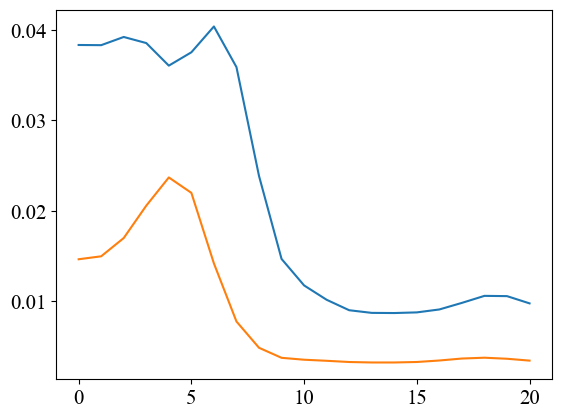

In [16]:
key = 'trial_2_dz_6_bs_128'
plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma))

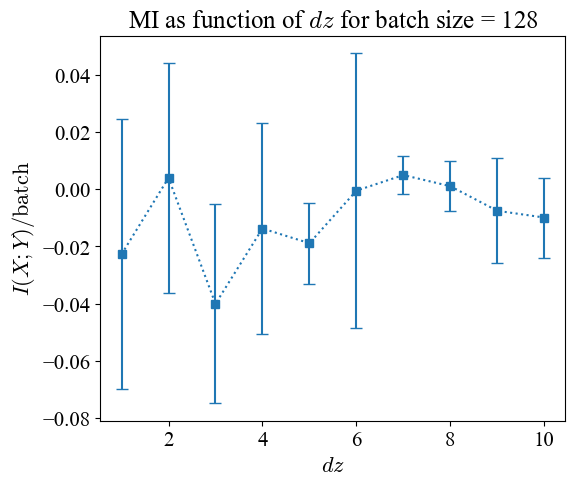

In [13]:
EMA_SPAN = 5 # smoothing, set to 1 if you don't want smoothing
dz_means = []
dz_stds = []

fig, ax = plt.subplots(figsize=(6,5))
for dz in range(1, params['max_dz']+1):
    mi_trials = []
    for j in range(params['n_trials']):
        key = f"trial_{j}_dz_{dz}_bs_128"

        # Define sigma, a small number is usually the best choice
        sigma=1 # (or 2 at most)
        # Convert Nan to zeros and smooth
        train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma)
        test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma)

        # Pick the epoch with highest test value and get corresponding train
        best = np.argmax(test)
        
        mi_trials.append(train[best])

    dz_means.append(np.mean(np.array(mi_trials)).flatten())
    dz_stds.append(np.std(np.array(mi_trials)).flatten())


b = ax.errorbar(
    range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
    yerr=np.array(dz_stds).flatten(), 
    fmt='s:', capsize=4)

# Set title and scales
ax.set_title(r"MI as function of $dz$ for batch size = "+str(params['batch_size']))
ax.set_xlabel(r'$dz$')
ax.set_ylabel(r'$I(X;Y)/\text{batch}$');


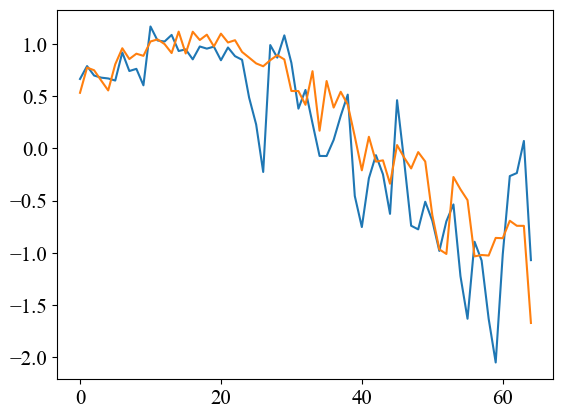

In [23]:
plt.plot(mi['trial_1_dz_5'] * np.log2(np.e))
plt.plot(mi_test['trial_1_dz_5'] * np.log2(np.e))

In [36]:
13 * 10 * 5 * 10 / 60 / 12

9.027777777777777

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes